In [1]:
import hmftpy as hmf
from hmftpy.plaquettes.triangular import plaq12, plaq12z, plaq9p, plaq9d, plaq3
from hmftpy.operators import mf_ops, inner_hamiltonian, periodic_hamiltonian
from hmftpy import do_hmft
from hmftpy.hmf import get_mfs
from hmftpy.plot_spins import draw_tri_lattice, draw_cluster, plot_spins
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

plaq = plaq12
L = plaq['L']
basis = spin_basis_1d(L, pauli=0)

ops = hmf.operators.mf_ops(plaq, basis)
maxit=50

# TODO

Local nematic order

# $J_1$-$J_2$ triangular-lattice XY antiferromagnet

The antiferromagnetic $J_1$-$J_2$ model Heisenberg model on the triangular lattice show two ordered phases. For low $J_2/J_1$, the spins orient with 120$^\circ$ relative to each other, taking three directions along the three sublattices. At higher $J_2/J_1$, the spins instead align along stripes. Near $J_2/J_1=1/8$, which is where the transition occurs classically, a phase with no local magnetic order arises. Some literature describes this phase as a spin liquid.

In the XY model, the same ordered phases arise, and I see a similar nonmagnetic phase between $J_2/J_1 \approx 0.1$ and $0.25$, similarly to the Heisenberg model.

In this notebook, I recreate some of the order parameters studied in a paper from 2016 by Alexander Wietek (https://doi.org/10.1103/PhysRevB.95.035141), which uses ED to measure certain order parameters and correlators in the Heisenberg model with and without an additional chiral term. Here, I don't add any chiral terms to the Hamiltonian, so my results should be compared to the bottom line of the heatmaps in Fig. 2 of Wietek's paper.

## Correlators from Wietek et. al.
Wietek et. al. defines the summed scalar chirality as
\begin{equation}
\chi = \sum_{(i,j,k)\in \triangle}\langle \chi_{012}\chi_{ijk}\rangle
\end{equation}
where $\chi_{ijk} = S_i \cdot (S_j \times S_k)$,
and a nematic order parameter
\begin{equation}
\mathcal N = \sum_{(i,j) \parallel (0, 1)}\langle (S_0 \cdot S_1)(S_i \cdot S_j)\rangle.
\end{equation}
For these, the sites 0, 1, and 2 should be in a triangle but are otherwise whatever.

They also looks at the magnetic structure factors 
\begin{equation}
S(\vec k) = \frac{1}{N}\left|\sum_j e^{i\vec k \cdot (\vec r_j - \vec r_0)}\vec S_j\cdot \vec S_0\right|^2.
\end{equation}
at the $K$ and $M$ points in the first Brillouin zone.

With the cluster illustrated below, I will measure these for two choices of the triangle "012": sites 4, 5, and 8 (in the center) and 0, 1, and 4 on the edge. Similarly, I will measure the nematic order parameter for sites 0 and 1 and for sites 4 and 5.

In [2]:
def couplings(J2, alpha=0, J3=0):
    interactions = {'local': {},
                    'nearest': {'xx': 1, 'yy': 1, 'zz': alpha},
                    'n_nearest': {'xx': J2, 'yy': J2, 'zz': alpha*J2},
                    'n_n_nearest': {'xx': J3, 'yy': J3, 'zz': alpha*J3},}
    return interactions

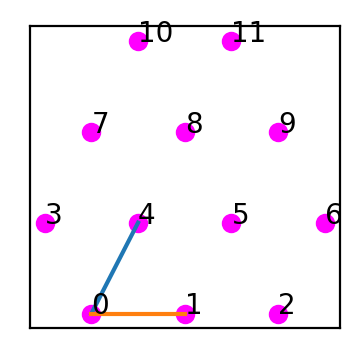

In [3]:
a1 = np.array((1, 0))
a2 = np.array((-0.5, 0.5*np.sqrt(3)))
a0 = np.array((0.5, 0.5*np.sqrt(3)))

b1 = 2*np.pi*np.array((1, -1/np.sqrt(3)))
b2 = 4*np.pi*np.array((0, 1/np.sqrt(3)))

M = np.pi*np.array((1, 1/np.sqrt(3)))
K = np.pi*np.array((4/3, 0))

plt.figure(figsize=(2,2), dpi=200)
rs = [(0,0), a1, 2*a1,
      a2, a2+a1, a2+2*a1, a2+3*a1,
      2*a2+a1, 2*a2+2*a1, 2*a2+3*a1,
      3*a2+2*a1, 3*a2+3*a1]
rx = [r[0] for r in rs]
ry = [r[1] for r in rs]
plt.scatter(rx, ry, color='magenta')
for i, r in enumerate(rs):
    plt.text(r[0], r[1], i)
plt.plot([0, a0[0]], [0, a0[1]])
plt.plot([0, a1[0]], [0, a1[1]])
plt.xticks([])
plt.yticks([])
plt.show()



## Defining operators

Here I define the operators to measure the observables previously mentioned.

In [4]:
def scalar_chirality(sites, basis):
    a, b, c = sites
    op_lst = [['xyz', [[1, a, b, c], [-1, a, c, b]]],
              ['yzx', [[1, a, b, c], [-1, a, c, b]]],
              ['zxy', [[1, a, b, c], [-1, a, c, b]]],
             ]
    return quantum_operator({'static': op_lst}, basis=basis, check_symm=False, check_herm=False)

def nematic_ops(sites, basis):
    a, b = sites
    op_lst = [['xx', [[1, a, b]]],
              ['yy', [[1, a, b]]],
              ['zz', [[1, a, b]]]
             ]
    return quantum_operator({'static': op_lst}, basis=basis, check_symm=False, check_herm=False)

urts = [[4,0,1],
        [5,1,2],
        [7,3,4],
        [8,4,5],
        [9,5,6],
        [10,7,8],
        [11,8,9]]

pbonds = [[0,1], [1,2], [3,4], [4,5], [5,6], [7,8], [8,9], [10,11]]

chi_ops = [scalar_chirality(s, basis) for s in urts]
nem_ops = [nematic_ops(s, basis) for s in pbonds]

def get_chis(v, ind0=3):
    chi = 0.
    for op in chi_ops:
        chi += chi_ops[ind0].matrix_ele(v, op.dot(v))
    return np.real(chi)

def get_nems(v, ind0=3):
    nem = 0.
    for op in nem_ops:
        nem += nem_ops[ind0].matrix_ele(v, op.dot(v)) 
    return np.real(nem)

x_ops = [quantum_operator({'static': [['x', [[1, i]]]]}, basis=basis, 
                          check_symm=False, check_herm=False) for i in range(12)]
y_ops = [quantum_operator({'static': [['x', [[1, i]]]]}, basis=basis, 
                          check_symm=False, check_herm=False) for i in range(12)]
z_ops = [quantum_operator({'static': [['x', [[1, i]]]]}, basis=basis, 
                          check_symm=False, check_herm=False) for i in range(12)]
def get_struct(k, v, ind0=3):
    struct = 0.
    for i in range(12):
        factor = np.exp(1j*np.dot(k, rs[i]))
        struct += factor*(x_ops[i].matrix_ele(v, x_ops[ind0].dot(v))
                          + y_ops[i].matrix_ele(v, y_ops[ind0].dot(v))
                          + z_ops[i].matrix_ele(v, z_ops[ind0].dot(v)))
    return np.abs(struct)**2/12

def ni_op(plaq, basis):
    A, B, C = plaq['n_nearest_sublattice']
    a_op = quantum_operator({'static': [['x', [[1/len(A), j] for j in A]]]}, basis=basis, check_symm=False, check_herm=False)
    b_op = quantum_operator({'static': [['x', [[-0.5/len(B), j] for j in B]],
                                        ['y', [[0.5*np.sqrt(3)/len(B), j] for j in B]]]}, basis=basis, check_symm=False, check_herm=False)
    c_op = quantum_operator({'static': [['x', [[-0.5/len(C), j] for j in C]],
                                        ['y', [[-0.5*np.sqrt(3)/len(C), j] for j in C]]]}, basis=basis, check_symm=False, check_herm=False)
    return a_op + b_op + c_op

def measure_ops(v, ind0):
    return get_chis(v, ind0=ind0), get_nems(v, ind0=ind0), get_struct(K, v, ind0=ind0), get_struct(M, v, ind0=ind0)


singlet_bonds = [[[0,3], [1,4], [2,6], [5,9], [7,8], [10,11]],
                 [[0,3], [4,7], [2,6], [1,5], [8,9], [10,11]],
                 [[0,4], [3,7], [10,8], [11,9], [5,6], [1,2]],
                 [[0,1], [3,4], [7,10], [8,11], [9,6], [5,2]]]
singlet_ops = [None for i in range(4)]
for i in range(4):
    singlet_ops[i] = quantum_operator({'static': [['xx', [[1, sb[0], sb[1]] for sb in singlet_bonds[i]]],
                                          ['yy', [[1, sb[0], sb[1]] for sb in singlet_bonds[i]]],
                                          ['zz', [[1, sb[0], sb[1]] for sb in singlet_bonds[i]]]
                                         ]}, basis=basis)

def get_singlets(v):
    singlets = np.real(np.array([sop.expt_value(v) for sop in singlet_ops]))
    return singlets

def get_squared_singlets(v):
    sq_singlets = np.real(np.array([sop.matrix_ele(v, sop.dot(v)) for sop in singlet_ops]))
    return sq_singlets

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


# $J_1$-$J_2$ models
Now, I construct arrays to store the results and then perform HMFT for values of $J_2$ falling between 0 and 0.3, with $J_1=1$. To make sure I capture all phases, I run from low to high $J_2$ using the previous mean-field to initiate the next step, and then repeat from high to low doing the same. I know from experience that both will capture the intermediate phase, so I can join them at that point. I also calculate ground-state results from the cluster with open boundary conditions, which matches in the intermediate phase (where all mean-fields are zero).

In [5]:
J2s = np.linspace(0, 1, 50)
t_ind = np.argmin(np.abs(J2s-0.2))
h_ind = np.argmin(np.abs(J2s-0.4))
m_op = ni_op(plaq, basis)


l = len(J2s)
labels = ['inner', 'inner_H', 'lr', 'rl', 'rl_H', 'lr_H']
energies = {lab: np.zeros(l) for lab in labels}

mfs = {lab: [None for i in range(l)] for lab in labels}
cvgs = {lab: np.zeros(l) for lab in labels}

chis_edge = {lab: np.zeros(l) for lab in labels}
chis_center = {lab: np.zeros(l) for lab in labels}

nems_edge = {lab: np.zeros(l) for lab in labels}
nems_center = {lab: np.zeros(l) for lab in labels}

k_s_edge = {lab: np.zeros(l) for lab in labels}
k_s_center = {lab: np.zeros(l) for lab in labels}

m_s_edge = {lab: np.zeros(l) for lab in labels}
m_s_center = {lab: np.zeros(l) for lab in labels}

m120s = {lab: np.zeros(l) for lab in labels}

singlets_1 = {lab: np.zeros(l) for lab in labels}
singlets_2 = {lab: np.zeros(l) for lab in labels}

In [6]:
mf0 = None
mf0_h = None
print('Running left to right XY and Heisenberg')
for i, J2 in enumerate(tqdm(J2s[:t_ind+5], ascii=True)):
    interactions = couplings(J2)
    energies['lr'][i], v, mfs['lr'][i], cvgs['lr'][i] = do_hmft(plaq, interactions, basis, 
                                                                max_iter=maxit, mf0=mf0,
                                                                ops=ops,
                                                                mf_cvg=False, every_other=True)
    mf0 = mfs['lr'][i]
    chis_edge['lr'][i], nems_edge['lr'][i], k_s_edge['lr'][i], m_s_edge['lr'][i] = measure_ops(v, 0)
    chis_center['lr'][i], nems_center['lr'][i], k_s_center['lr'][i], m_s_center['lr'][i] = measure_ops(v, 3)
    m120s['lr'][i] = np.real(m_op.matrix_ele(v, m_op.dot(v)))
    singlets_1['lr'][i], _, singlets_2['lr'][i], _ = get_singlets(v)
    
for i, J2 in enumerate(tqdm(J2s[:h_ind+5], ascii=True)):
    interactions = couplings(J2, alpha=1, J3=0)
    energies['lr_H'][i], v, mfs['lr_H'][i], cvgs['lr_H'][i] = do_hmft(plaq, interactions, basis, 
                                                                max_iter=maxit, mf0=mf0_h,
                                                                ops=ops,
                                                                mf_cvg=False, every_other=True)
    mf0_h = mfs['lr_H'][i]
    chis_edge['lr_H'][i], nems_edge['lr_H'][i], k_s_edge['lr_H'][i], m_s_edge['lr_H'][i] = measure_ops(v, 0)
    chis_center['lr_H'][i], nems_center['lr_H'][i], k_s_center['lr_H'][i], m_s_center['lr_H'][i] = measure_ops(v, 3)
    
    m120s['lr_H'][i] = np.real(m_op.matrix_ele(v, m_op.dot(v)))
    singlets_1['lr_H'][i], _, singlets_2['lr_H'][i], _ = get_singlets(v)

  0%|          | 0/15 [00:00<?, ?it/s]

Running left to right XY and Heisenberg


100%|##########| 25/25 [00:12<00:00,  2.08it/s]


In [7]:
print('Running right to left XY and Heisenberg')
mf0 = None
mf0_h = None
for i, J2 in enumerate(tqdm(J2s[t_ind:][::-1], ascii=True)):
    j = l-1-i
    interactions = couplings(J2)
    energies['rl'][j], v, mfs['rl'][j], cvgs['rl'][j] = do_hmft(plaq, interactions, basis, 
                                                                max_iter=maxit, mf0=mf0, 
                                                                ops=ops,
                                                                mf_cvg=False, every_other=True)
    mf0 = mfs['rl'][j]
    chis_edge['rl'][j], nems_edge['rl'][j], k_s_edge['rl'][j], m_s_edge['rl'][j] = measure_ops(v, 0)
    chis_center['rl'][j], nems_center['rl'][j], k_s_center['rl'][j], m_s_center['rl'][j] = measure_ops(v, 3)
    m120s['rl'][j] = np.real(m_op.matrix_ele(v, m_op.dot(v)))
    singlets_1['rl'][j], _, singlets_2['rl'][j], _ = get_singlets(v)
    
for i, J2 in enumerate(tqdm(J2s[h_ind:][::-1], ascii=True)): 
    j = l-1-i
    interactions = couplings(J2, alpha=1, J3=0)
    energies['rl_H'][j], v, mfs['rl_H'][j], cvgs['rl_H'][j] = do_hmft(plaq, interactions, basis, 
                                                                max_iter=maxit, mf0=mf0_h, 
                                                                ops=ops,
                                                                mf_cvg=False, every_other=True)
    mf0_h = mfs['rl_H'][j]
    chis_edge['rl_H'][j], nems_edge['rl_H'][j], k_s_edge['rl_H'][j], m_s_edge['rl_H'][j] = measure_ops(v, 0)
    chis_center['rl_H'][j], nems_center['rl_H'][j], k_s_center['rl_H'][j], m_s_center['rl_H'][j] = measure_ops(v, 3)
    m120s['rl_H'][j] = np.real(m_op.matrix_ele(v, m_op.dot(v)))
    singlets_1['rl_H'][j], _, singlets_2['rl_H'][j], _ = get_singlets(v)

  0%|          | 0/40 [00:00<?, ?it/s]

Running right to left XY and Heisenberg


100%|##########| 30/30 [01:25<00:00,  2.86s/it]


For the ED calculations, I construct a smaller basis restricting us to $\sum_i S_i^z=0$. This speeds up the calculations and gives the same ground state, but doesn't work in the HMFT calculations because the mean-field terms break symmetries.

In [10]:
print('Performing ED calculations')

b_ed = spin_basis_1d(12, Nup=6, pauli=0)
degens = np.zeros(l)

for i, J2 in enumerate(tqdm(J2s, ascii=True)):
    interactions = couplings(J2, alpha=0)

    Hi = inner_hamiltonian(plaq, interactions, b_ed, every_other=True)
    e, v = Hi.eigsh(k=20, which='SA')
    i0 = np.argmin(e)
    energies['inner'][i] = e[i0]
    v0 = b_ed.project_from(v[:, i0], sparse=False)
    chis_edge['inner'][i], nems_edge['inner'][i], k_s_edge['inner'][i], m_s_edge['inner'][i] = measure_ops(v0, 0)
    chis_center['inner'][i], nems_center['inner'][i], k_s_center['inner'][i], m_s_center['inner'][i] = measure_ops(v0, 3)
    m120s['inner'][i] = np.real(m_op.matrix_ele(v0, m_op.dot(v0)))
    singlets_1['inner'][i], _, singlets_2['inner'][i], _ = get_singlets(v0)
                              
    interactions = couplings(J2, alpha=1, J3=0)
    
    Hi = inner_hamiltonian(plaq, interactions, b_ed, every_other=True)
    e, v = Hi.eigsh(k=20, which='SA')
    i0 = np.argmin(e)
    energies['inner_H'][i] = e[i0]
    v0 = b_ed.project_from(v[:, i0], sparse=False)
    chis_edge['inner_H'][i], nems_edge['inner_H'][i], k_s_edge['inner_H'][i], m_s_edge['inner_H'][i] = measure_ops(v0, 0)
    chis_center['inner_H'][i], nems_center['inner_H'][i], k_s_center['inner_H'][i], m_s_center['inner_H'][i] = measure_ops(v0, 3)
    m120s['inner_H'][i] = np.real(m_op.matrix_ele(v0, m_op.dot(v0)))
    singlets_1['inner_H'][i], _, singlets_2['inner_H'][i], _ = get_singlets(v0)

  0%|          | 0/50 [00:00<?, ?it/s]

Performing ED calculations


100%|##########| 50/50 [00:32<00:00,  1.52it/s]


## Plotting results

It seems most appropriate to consider cases where we choose the site/triangle/dimer in the order parameters to be near the center of the clusters, so let's plot those first.

Note that from the energy plot, we see the HMFT results mirror the open BC ED results in certain places. That is because after moving into the disordered phase, the HMFT calculation stays at the 0 mean-field solution even when a lower solution is possible.

When plotting order parameters, I cut the HMFT results in half and join them at $J_2=0.15$, in the disordered phase. In these plots, I label the low to high (left to right) run HMFT I, and the other HMFT II.

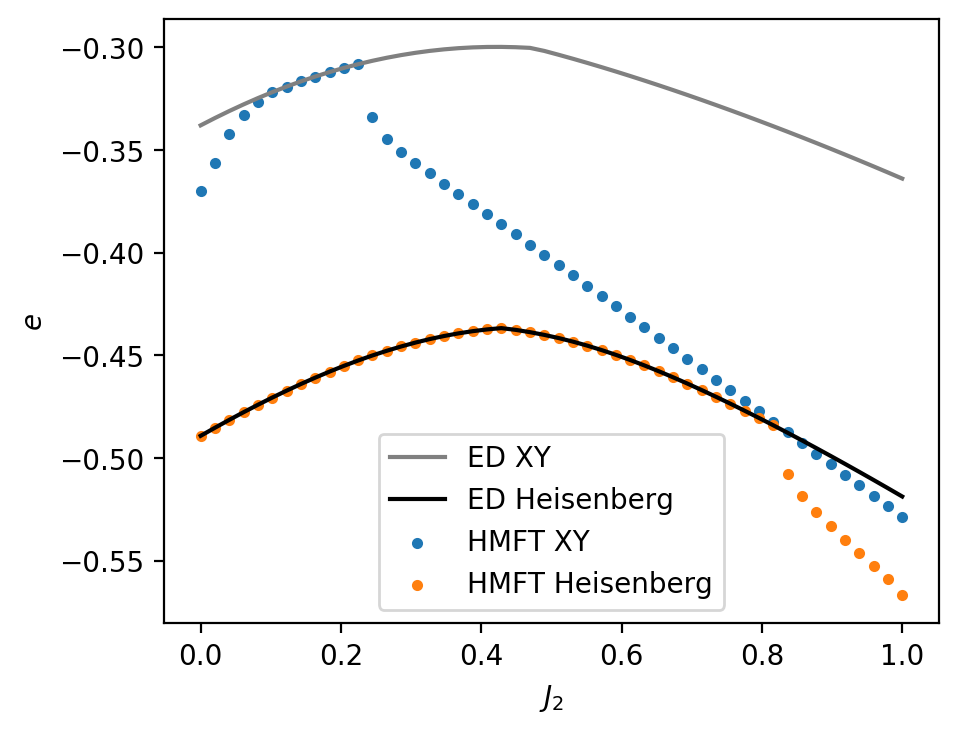

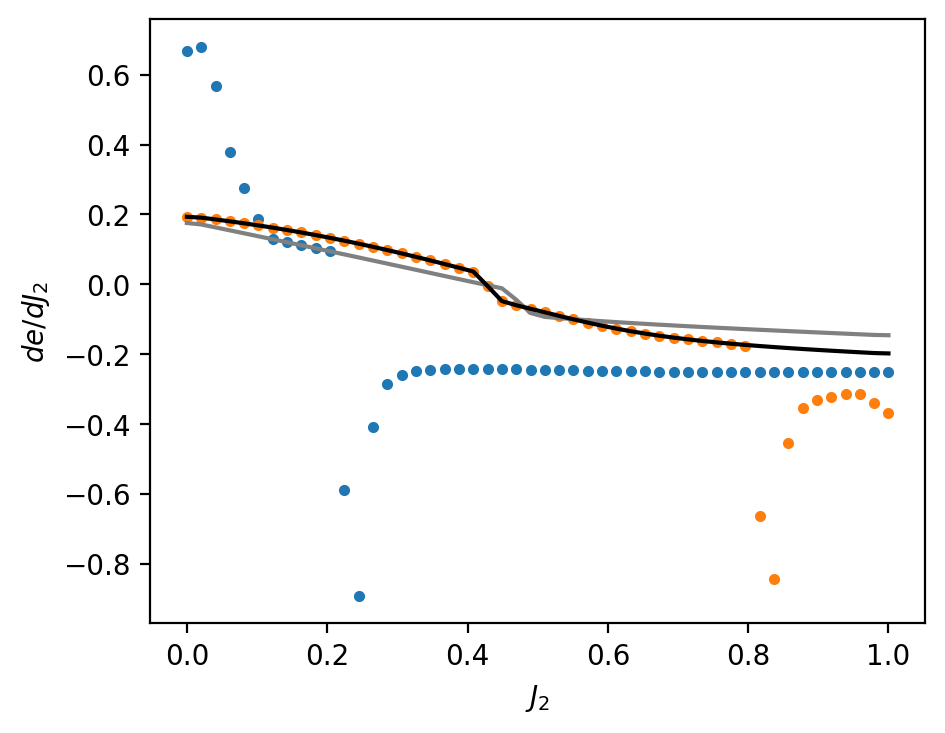

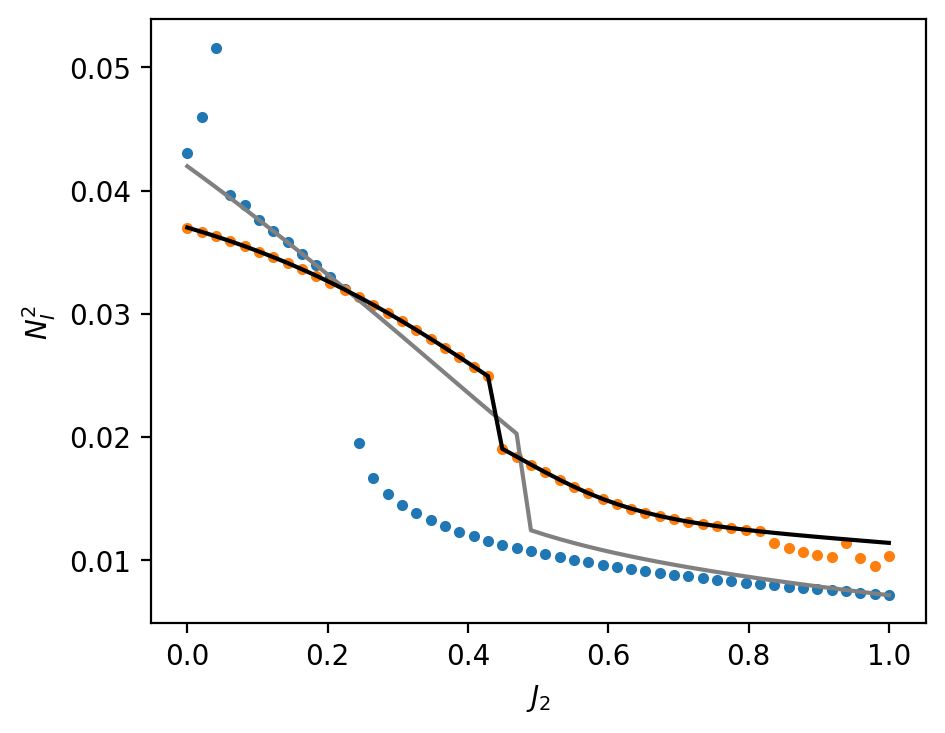

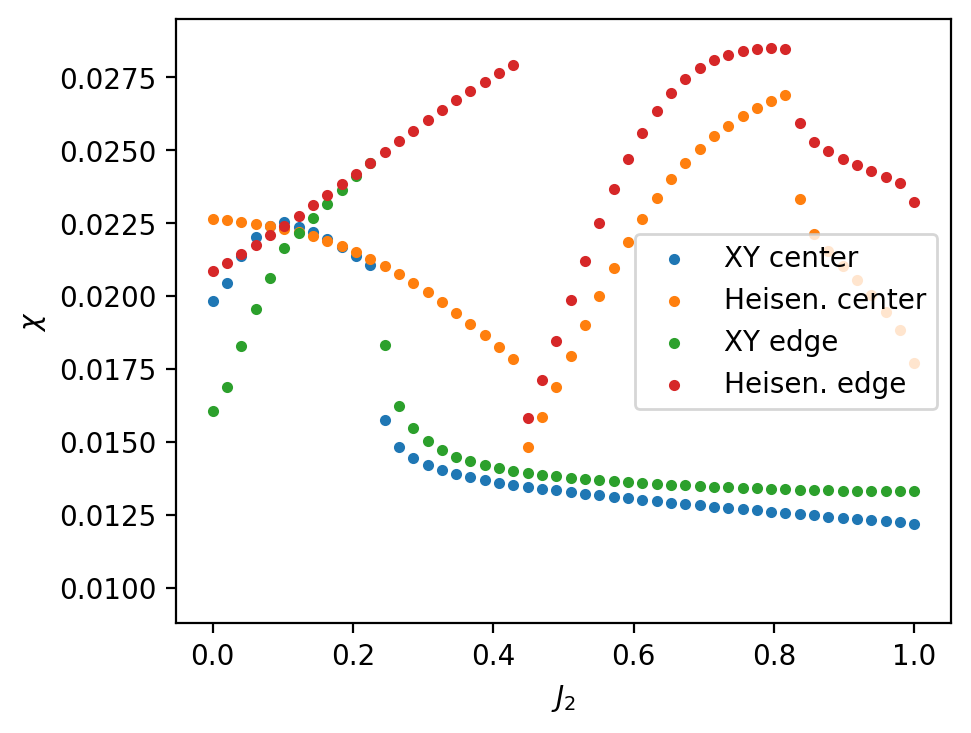

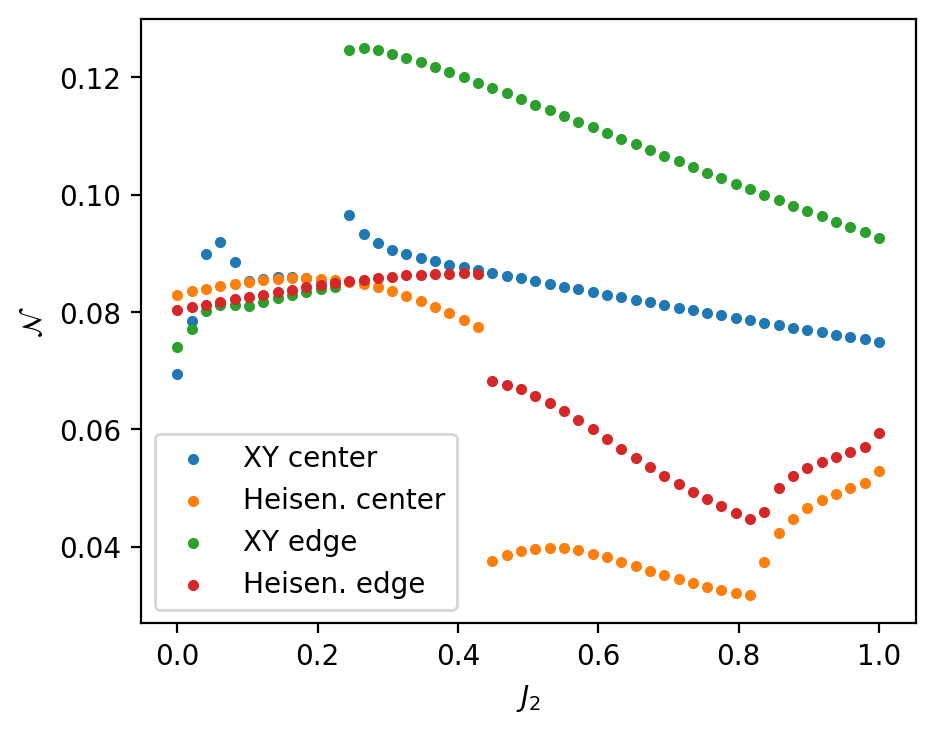

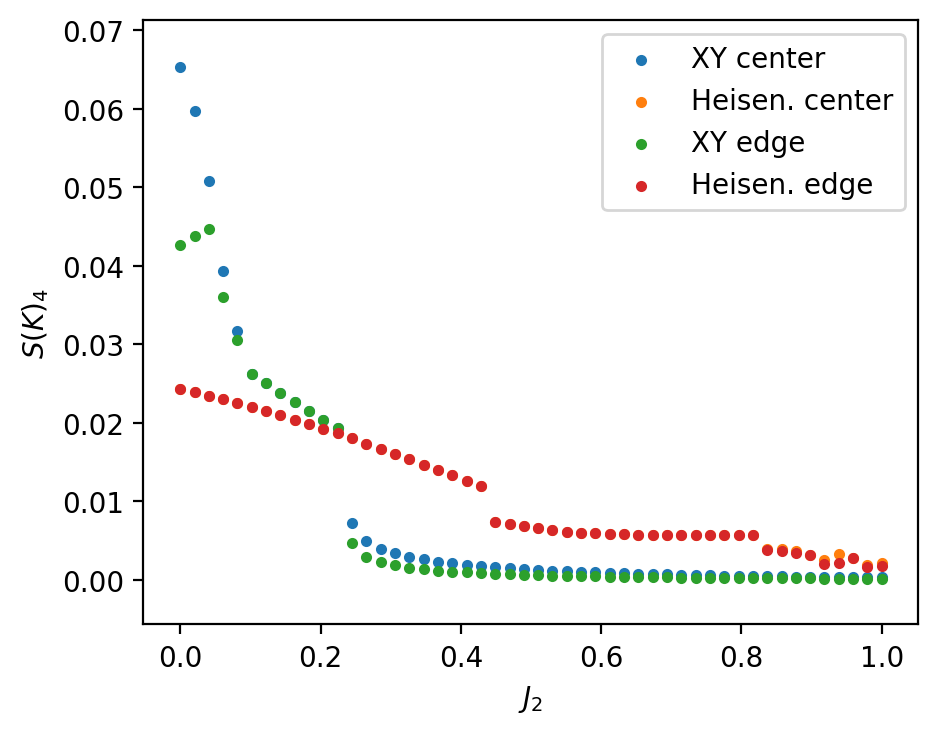

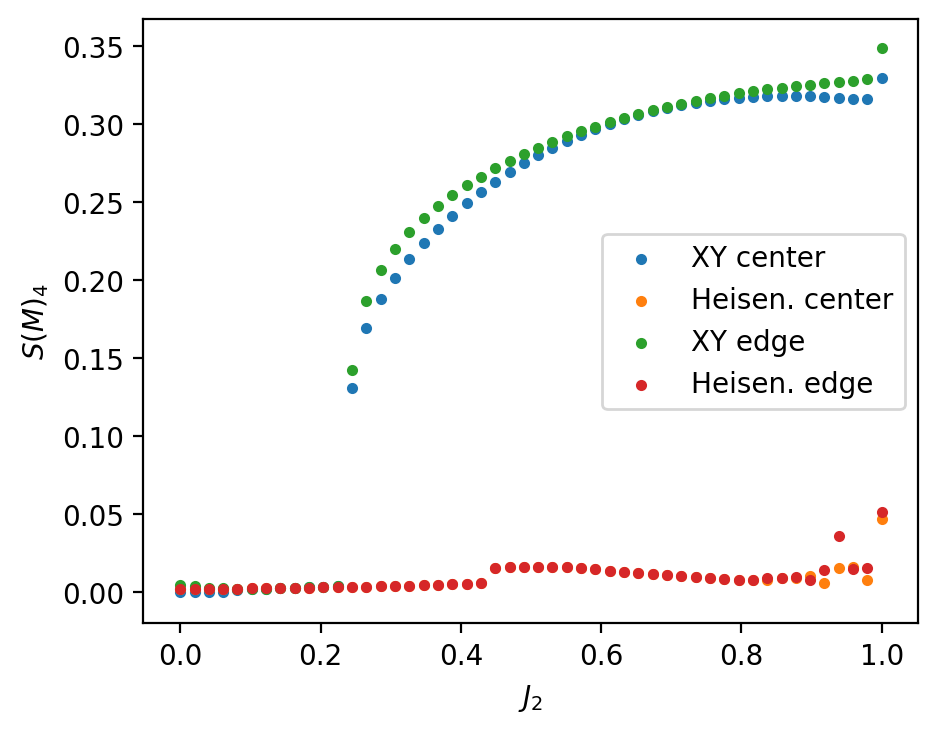

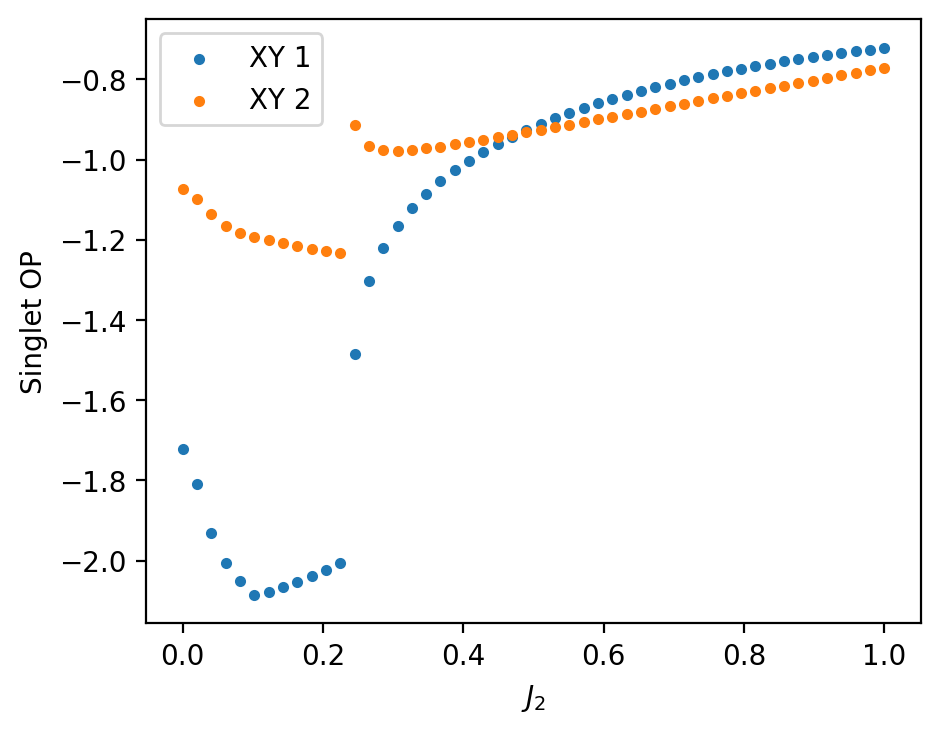

In [13]:
plt.figure(figsize=(5,4), dpi=200)
plt.plot(J2s, energies['inner']/12, label='ED XY', color='gray', zorder=100)
plt.plot(J2s, energies['inner_H']/12, label='ED Heisenberg', color='black', zorder=100)
plt.scatter(J2s, np.concatenate([energies['lr'][:t_ind], energies['rl'][t_ind:]])/12, label='HMFT XY', marker='.')
plt.scatter(J2s, np.concatenate([energies['lr_H'][:h_ind], energies['rl_H'][h_ind:]])/12, label='HMFT Heisenberg', marker='.')

plt.xlabel(r'$J_2$')
plt.ylabel(r'$e$')
plt.legend()
plt.show()

plt.figure(figsize=(5,4), dpi=200)
plt.plot(J2s, np.gradient(energies['inner'], J2s)/12, label='ED XY', color='gray', zorder=100)
plt.plot(J2s, np.gradient(energies['inner_H'], J2s)/12, label='ED Heisenberg', color='black', zorder=100)
plt.scatter(J2s, np.gradient(np.concatenate([energies['lr'][:t_ind], energies['rl'][t_ind:]])/12, J2s), label='HMFT XY', marker='.')
plt.scatter(J2s, np.gradient(np.concatenate([energies['lr_H'][:h_ind], energies['rl_H'][h_ind:]])/12, J2s), label='HMFT Heisenberg', marker='.')
plt.xlabel(r'$J_2$')
plt.ylabel(r'$de/dJ_2$')
plt.show()

plt.figure(figsize=(5,4), dpi=200)
plt.plot(J2s, m120s['inner']/12, label='ED XY', color='gray', zorder=100)
plt.plot(J2s, m120s['inner_H']/12, label='ED Heisenberg', color='black', zorder=100)
plt.scatter(J2s, np.concatenate([m120s['lr'][:t_ind], m120s['rl'][t_ind:]])/12, label='HMFT XY', marker='.')
plt.scatter(J2s, np.concatenate([m120s['lr_H'][:h_ind], m120s['rl_H'][h_ind:]])/12, label='HMFT Heisenberg', marker='.')
plt.xlabel(r'$J_2$')
plt.ylabel(r'$N_I^2$')

plt.show()


plt.figure(figsize=(5,4), dpi=200)
plt.scatter(J2s, np.concatenate([chis_center['lr'][:t_ind], chis_center['rl'][t_ind:]])/12, label='XY center', marker='.')
plt.scatter(J2s, np.concatenate([chis_center['lr_H'][:h_ind], chis_center['rl_H'][h_ind:]])/12, label='Heisen. center', marker='.')
plt.scatter(J2s, np.concatenate([chis_edge['lr'][:t_ind], chis_edge['rl'][t_ind:]])/12, label='XY edge', marker='.')
plt.scatter(J2s, np.concatenate([chis_edge['lr_H'][:h_ind], chis_edge['rl_H'][h_ind:]])/12, label='Heisen. edge', marker='.')
plt.xlabel(r'$J_2$')
plt.ylabel(r'$\chi$')
plt.legend()
plt.show()

plt.figure(figsize=(5,4), dpi=200)
# plt.plot(J2s, nems_center['inner'], label='ED XY', color='gray', zorder=100)
plt.scatter(J2s, np.concatenate([nems_center['lr'][:t_ind], nems_center['rl'][t_ind:]])/12, label='XY center', marker='.')
plt.scatter(J2s, np.concatenate([nems_center['lr_H'][:h_ind], nems_center['rl_H'][h_ind:]])/12, label='Heisen. center', marker='.')
plt.scatter(J2s, np.concatenate([nems_edge['lr'][:t_ind], nems_edge['rl'][t_ind:]])/12, label='XY edge', marker='.')
plt.scatter(J2s, np.concatenate([nems_edge['lr_H'][:h_ind], nems_edge['rl_H'][h_ind:]])/12, label='Heisen. edge', marker='.')
plt.xlabel(r'$J_2$')
plt.ylabel(r'$\mathcal{N}$')
plt.legend()
plt.show()

plt.figure(figsize=(5,4), dpi=200)
# plt.plot(J2s, k_s_center['inner'], label='ED XY', color='gray', zorder=100)
plt.scatter(J2s, np.concatenate([k_s_center['lr'][:t_ind], k_s_center['rl'][t_ind:]])/12, label='XY center', marker='.')
plt.scatter(J2s, np.concatenate([k_s_center['lr_H'][:h_ind], k_s_center['rl_H'][h_ind:]])/12, label='Heisen. center', marker='.')
plt.scatter(J2s, np.concatenate([k_s_edge['lr'][:t_ind], k_s_edge['rl'][t_ind:]])/12, label='XY edge', marker='.')
plt.scatter(J2s, np.concatenate([k_s_edge['lr_H'][:h_ind], k_s_edge['rl_H'][h_ind:]])/12, label='Heisen. edge', marker='.')
plt.xlabel(r'$J_2$')
plt.ylabel(r'$S(K)_4$')
plt.legend()
plt.show()

plt.figure(figsize=(5,4), dpi=200)
# plt.plot(J2s, m_s_center['inner'], label='ED XY', color='gray', zorder=100)
plt.scatter(J2s, np.concatenate([m_s_center['lr'][:t_ind], m_s_center['rl'][t_ind:]])/12, label='XY center', marker='.')
plt.scatter(J2s, np.concatenate([m_s_center['lr_H'][:h_ind], m_s_center['rl_H'][h_ind:]])/12, label='Heisen. center', marker='.')
plt.scatter(J2s, np.concatenate([m_s_edge['lr'][:t_ind], m_s_edge['rl'][t_ind:]])/12, label='XY edge', marker='.')
plt.scatter(J2s, np.concatenate([m_s_edge['lr_H'][:h_ind], m_s_edge['rl_H'][h_ind:]])/12, label='Heisen. edge', marker='.')
plt.xlabel(r'$J_2$')
plt.ylabel(r'$S(M)_4$')
plt.legend()
plt.show()


plt.figure(figsize=(5,4), dpi=200)
# plt.plot(J2s, m_s_center['inner'], label='ED XY', color='gray', zorder=100)
plt.scatter(J2s, np.concatenate([singlets_1['lr'][:t_ind], singlets_1['rl'][t_ind:]]), label='XY 1', marker='.')
# plt.scatter(J2s, singlets_1['inner'], label='Heisen. 1', marker='.')
plt.scatter(J2s, np.concatenate([singlets_2['lr'][:t_ind], singlets_2['rl'][t_ind:]]), label='XY 2', marker='.')
# plt.scatter(J2s, singlets_2['inner'], label='Heisen. 1', marker='.')
plt.xlabel(r'$J_2$')
plt.ylabel(r'Singlet OP')
plt.legend()
plt.show()